# Sonification of Spectograms
Within this notebook, we explain how ```libsoni.core.spectrum``` can be used to sonify spectrograms.

In [1]:
import librosa
import librosa.display
import numpy as np
import os
from IPython import display as ipd
import matplotlib.pyplot as plt
import libfmp

from libsoni.core.spectrogram import sonify_spectrogram
from libsoni.core.methods import generate_tone_additive_synthesis

%matplotlib inline

Fs = 22050
N = 4096
H = 2048

## Simple Scenario
To make the use of the module ```libsoni.core.spectrum``` clear with a simple example, let's first assume a spectogram like an image. The vertical axis is attributed to frequency in conventional formats, while the horizontal axis represents time. Let's say we want to create an image for a C major scale. For this we need a frequency axis that keeps the frequencies of the notes of a C major scale

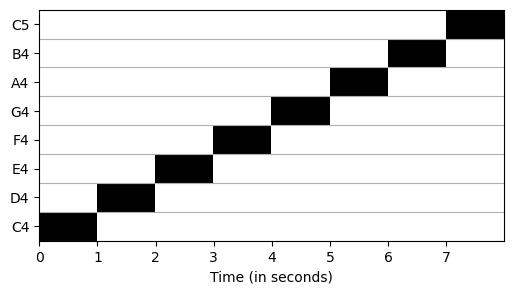

In [2]:
c_major_pitch_frequencies = [261.63, 293.66, 329.63, 349.23, 392.00, 440.00, 493.88, 523.25]
c_major_pitches = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5']

times = np.arange(8)
image = np.zeros((len(c_major_pitch_frequencies), len(times)))

for i in range(image.shape[0]):
    image[i,i]=1 
    
plt.figure(figsize=(6,3))

ax = plt.gca();

ax.set_xticks(np.arange(-0.5, 7, 1), minor=True)

ax.set_yticks(np.arange(-0.5, 7, 1), minor=True)
ax.tick_params(which='minor', left=False)

plt.grid(which='minor', linestyle='-')


ax.set_yticks(np.arange(0, 8, 1), labels=c_major_pitches, minor=False)
ax.set_xticks(np.arange(-0.5, 7, 1), times, minor=False)

plt.xlabel('Time (in seconds)')

plt.imshow(image, cmap='gray_r', aspect='auto', origin='lower')
x = sonify_spectrogram(image, c_major_pitch_frequencies, times)
ipd.display(ipd.Audio(x, rate=Fs))

## Running Example:  *Frühlingstraum* by *Franz Schubert*
<img src="figures/demo_spectrum/Schubert_D911-11_score.png" alt="Gute Nacht" width="600">

In [3]:
fn_wav = os.path.join('data_audio','demo_spectrum','FMP_B_Sonify_Pitch_Schubert_D911-11_SC06.wav')
Fs = 22050

x, Fs = librosa.load(fn_wav, sr=Fs)
print('Frühlingstraum by Franz Schubert:')
ipd.display(ipd.Audio(x, rate=Fs))

Frühlingstraum by Franz Schubert:


## Scenario: STFT
To start with a simple example, we create a sound using ```libsoni.core.methods``` and calculate its STFT.

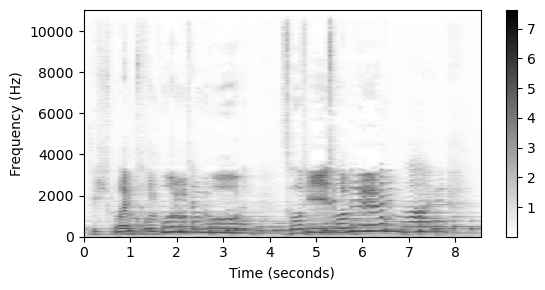

Sonified STFT:


In [4]:
X = np.abs(librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True))

T_coef = np.arange(X.shape[1]) * H / Fs
F_coef = np.arange(N // 2 +1) * Fs / N

plt.figure(figsize=(6, 3))
extent = [T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]]
plt.imshow(np.log(1+5*X), cmap='gray_r', aspect='auto', origin='lower', extent=extent)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.tight_layout()
plt.show()

x_resynthesized = sonify_spectrogram(X, F_coef, T_coef)
print('Sonified STFT:')
ipd.display(ipd.Audio(x_resynthesized, rate = Fs))

## Scenario: CQT

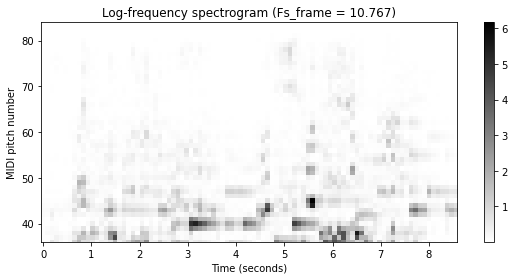

Sonified CQT:


In [5]:
# Log-frequency spectrogrm from audio recording
X_CQT = np.abs(librosa.cqt(y=x, sr=Fs, hop_length=H, n_bins=84, bins_per_octave=12, norm=1))


frequencies = [440 * (2 ** ((midi_pitch - 69) / 12)) for midi_pitch in range(24, 24+84)]
times = np.arange(X_CQT.shape[1]) * H / Fs



Fs_frame = Fs / H

title='Log-frequency spectrogram (Fs_frame = %.3f)' % Fs_frame

libfmp.b.plot_matrix(X_CQT, Fs=Fs_frame, ylabel='MIDI pitch number',
                     title=title, figsize=(8, 4))
plt.ylim([36, 84])
plt.show()


x_resynthesized = sonify_spectrogram(X_CQT, frequencies, times)
print('Sonified CQT:')
ipd.display(ipd.Audio(x_resynthesized, rate=Fs))

## Scenario: Mel-Spectrum

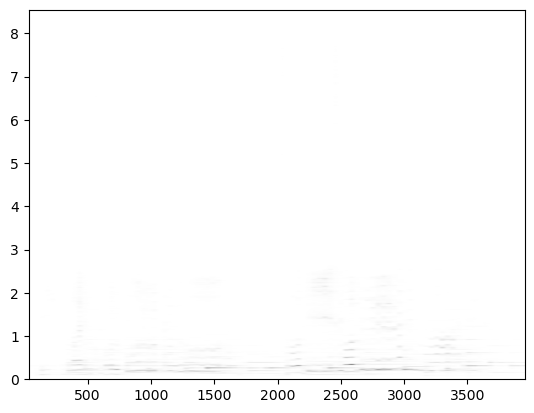

In [6]:
S = np.abs(librosa.feature.melspectrogram(y=x, sr=Fs))
extent=[frequencies[0], frequencies[-1], times[0], times[-1]]
plt.imshow(X, cmap='gray_r', aspect='auto', origin='lower', extent=extent)

frames = np.arange(S.shape[1])

# Convert frame indices to time (in seconds)
times = librosa.frames_to_time(frames)

# The frequency vector can be obtained using the center frequencies of the Mel bands.
mel_frequencies = librosa.core.mel_frequencies(n_mels=S.shape[0], fmin=0.0, fmax=Fs/2.0)

# Print the time and frequency vectors
#print("Time vector (in seconds):", times)
#print("Mel frequencies vector (in Hz):", mel_frequencies)

s = sonify_spectrogram(S, mel_frequencies, times)
ipd.display(ipd.Audio(s, rate = Fs))